Loaded heart_disease_selected.csv
Dataset shape: (303, 8)
Columns: ['thalach', 'oldpeak', 'slope', 'thal', 'ca', 'exang', 'cp', 'num']
Train/Test sizes: (242, 7) (61, 7)

=== LogisticRegression ===
Accuracy: 0.8689  Precision: 0.8125  Recall: 0.9286  F1: 0.8667  ROC_AUC: 0.9404761904761905

Classification report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.81      0.93      0.87        28

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.88      0.87      0.87        61


=== DecisionTree ===
Accuracy: 0.7705  Precision: 0.6944  Recall: 0.8929  F1: 0.7812  ROC_AUC: 0.7797619047619049

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.67      0.76        33
           1       0.69      0.89      0.78        28

    accuracy                           0.77        61

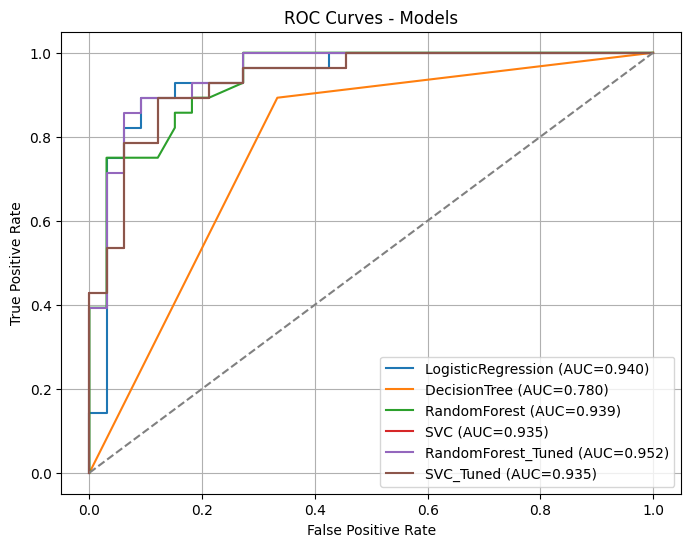

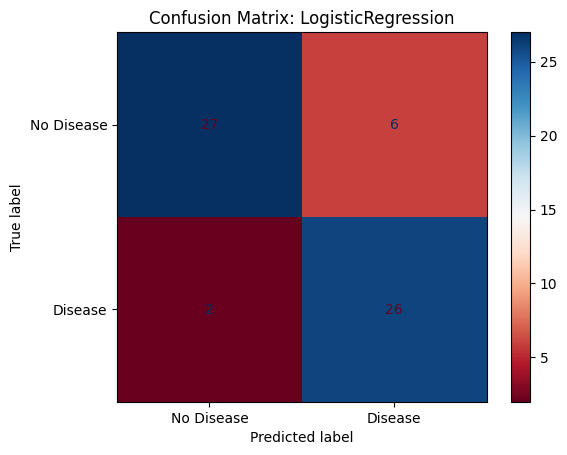

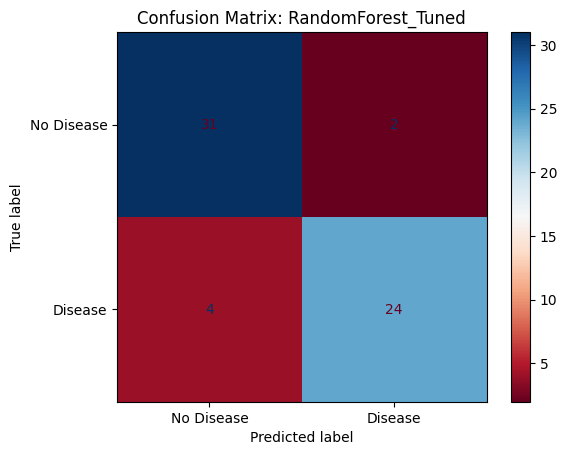

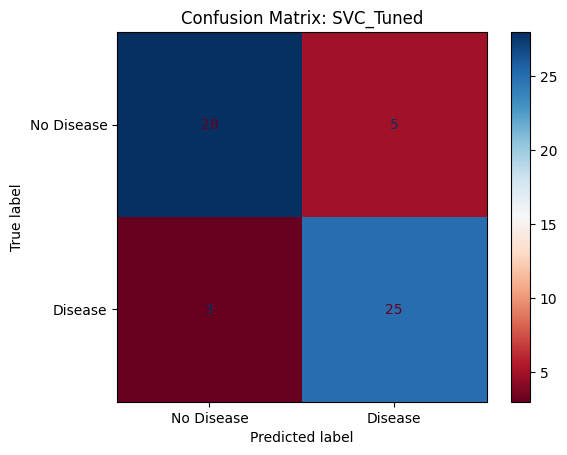


Best model by ROC_AUC: RandomForest_Tuned AUC: 0.9523809523809524
Saved best model to model_RandomForest_Tuned.pkl
Saved evaluation summary to results/evaluation_metrics.txt

Cross-val ROC AUC scores (5-fold) for selected classifiers:
LogisticRegression: mean AUC=0.896  std=0.028
RandomForest_Tuned: mean AUC=0.882  std=0.033


In [1]:
# 1. Imports
# =========================
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
    classification_report
)
import joblib

# Ensure results folder (optional)
os.makedirs("results", exist_ok=True)

# =========================
# 2. Load Data (selected features)
# =========================
if os.path.exists("/content/heart_disease_selected.csv"):
    data = pd.read_csv("/content/heart_disease_selected.csv")
    print("Loaded heart_disease_selected.csv")
else:
    print("WARNING: '/content/heart_disease_selected.csv' not found. Falling back to 'heart_disease_cleaned.csv'.")
    data = pd.read_csv("heart_disease_cleaned.csv")
    # if fallback, remove target column and keep numeric features (except target)
    # assume user will rerun feature selection later
print("Dataset shape:", data.shape)
print("Columns:", list(data.columns))

# =========================
# 3. Prepare X, y (binary target)
# =========================
target_col = "num"
if target_col not in data.columns:
    raise ValueError(f"Target column '{target_col}' not found in data.")

X = data.drop(columns=[target_col])
y = data[target_col].apply(lambda x: 1 if x > 0 else 0)  # binary: 0 vs 1+

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print("Train/Test sizes:", X_train.shape, X_test.shape)

# =========================
# 4. Helper: evaluate and save results
# =========================
def evaluate_model(name, model, X_test, y_test, y_pred_proba=None):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = None
    if y_pred_proba is not None:
        try:
            auc = roc_auc_score(y_test, y_pred_proba)
        except Exception:
            auc = None

    # print & return summary
    summary = {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": auc
    }
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}  Precision: {prec:.4f}  Recall: {rec:.4f}  F1: {f1:.4f}  ROC_AUC: {auc}")
    print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))
    return summary, y_pred

# =========================
# 5. Models to train (pipelines with scaler)
# =========================
models = {
    "LogisticRegression": Pipeline([("scaler", StandardScaler()), ("clf", LogisticRegression(max_iter=2000))]),
    "DecisionTree": Pipeline([("scaler", StandardScaler()), ("clf", DecisionTreeClassifier(random_state=42))]),
    "RandomForest": Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))]),
    "SVC": Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True, random_state=42))]),
}

# Train baseline models and collect metrics
results = []
trained_models = {}

for name, pipeline in models.items():
    pipeline.fit(X_train, y_train)
    trained_models[name] = pipeline
    # get probability for ROC (use predict_proba if available)
    y_proba = None
    if hasattr(pipeline.named_steps['clf'], "predict_proba"):
        y_proba = pipeline.predict_proba(X_test)[:, 1]
    else:
        # for SVC with probability=True we get predict_proba; otherwise fall back to decision_function
        if hasattr(pipeline.named_steps['clf'], "decision_function"):
            try:
                df = pipeline.decision_function(X_test)
                # scale to [0,1] via min-max for AUC if needed
                y_proba = (df - df.min()) / (df.max() - df.min())
            except Exception:
                y_proba = None
    summary, y_pred = evaluate_model(name, pipeline, X_test, y_test, y_proba)
    results.append(summary)

# =========================
# 6. Hyperparameter Tuning (GridSearch) - small grids
# =========================
# Random Forest tuning
rf_param_grid = {
    "clf__n_estimators": [50, 100],
    "clf__max_depth": [None, 6, 12],
}
rf_pipeline = Pipeline([("scaler", StandardScaler()), ("clf", RandomForestClassifier(random_state=42))])
rf_gs = GridSearchCV(rf_pipeline, rf_param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
rf_gs.fit(X_train, y_train)
print("\nRandomForest best params:", rf_gs.best_params_, "best score(cv):", rf_gs.best_score_)

# SVC tuning (RBF)
svc_param_grid = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", "auto"],
    "clf__kernel": ["rbf"]
}
svc_pipeline = Pipeline([("scaler", StandardScaler()), ("clf", SVC(probability=True, random_state=42))])
svc_gs = GridSearchCV(svc_pipeline, svc_param_grid, cv=5, scoring="roc_auc", n_jobs=-1)
svc_gs.fit(X_train, y_train)
print("\nSVC best params:", svc_gs.best_params_, "best score(cv):", svc_gs.best_score_)

# Save best from gridsearches
trained_models["RandomForest_Tuned"] = rf_gs.best_estimator_
trained_models["SVC_Tuned"] = svc_gs.best_estimator_

# Evaluate tuned models
for name in ["RandomForest_Tuned", "SVC_Tuned"]:
    model = trained_models[name]
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model.named_steps['clf'], "predict_proba") else None
    summary, _ = evaluate_model(name, model, X_test, y_test, y_proba)
    results.append(summary)

# =========================
# 7. ROC curves (all models)
# =========================
plt.figure(figsize=(8, 6))
for name, model in trained_models.items():
    # attempt to get probability scores for positive class
    y_scores = None
    if hasattr(model.named_steps['clf'], "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model.named_steps['clf'], "decision_function"):
        try:
            df = model.decision_function(X_test)
            y_scores = (df - df.min()) / (df.max() - df.min())
        except Exception:
            y_scores = None

    if y_scores is not None:
        fpr, tpr, _ = roc_curve(y_test, y_scores)
        auc = roc_auc_score(y_test, y_scores)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Models")
plt.legend()
plt.grid(True)
plt.show()

# =========================
# 8. Confusion Matrices for top models
# =========================
top_models = ["LogisticRegression", "RandomForest_Tuned", "SVC_Tuned"]
for name in top_models:
    if name not in trained_models:
        continue
    model = trained_models[name]
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Disease", "Disease"])
    disp.plot(cmap="RdBu")
    plt.title(f"Confusion Matrix: {name}")
    plt.show()

# =========================
# 9. Save best model and evaluation metrics
# =========================
# pick best by ROC_AUC among results (ignore None)
best = None
best_auc = -1
for r in results:
    auc = r.get("roc_auc")
    if auc is None:
        continue
    if auc > best_auc:
        best_auc = auc
        best = r["model"]

print("\nBest model by ROC_AUC:", best, "AUC:", best_auc)

# Save chosen model
if best is not None and best in trained_models:
    joblib.dump(trained_models[best], f"model_{best}.pkl")
    print(f"Saved best model to model_{best}.pkl")

# Save evaluation summary file
with open(os.path.join("results", "evaluation_metrics.txt"), "w") as f:
    f.write("Model evaluation summary\n\n")
    for r in results:
        f.write(f"{r}\n")
print("Saved evaluation summary to results/evaluation_metrics.txt")

# =========================
# 10. Optional: Cross-validation scores summary
# =========================
print("\nCross-val ROC AUC scores (5-fold) for selected classifiers:")
for name, model in [("LogisticRegression", models["LogisticRegression"]),
                    ("RandomForest_Tuned", trained_models.get("RandomForest_Tuned"))]:
    if model is None:
        continue
    scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc", n_jobs=-1)
    print(f"{name}: mean AUC={scores.mean():.3f}  std={scores.std():.3f}")
